In [378]:
import os
import geopandas as gpd
import pandas as pd
import folium
from shapely.geometry import Point
import matplotlib.pyplot as plt

litpoprobe_file = os.path.join("data", "lithoprobe.geojson")
monitoring_area_file = os.path.join("data", "KSMMA.geojson")
faults_file = os.path.join("data", "Mei_2009_faults.shp")
wells_file = os.path.join("data","wells_close_to_lithoprobe.csv")

In [379]:
lithoprobe = gpd.read_file(litpoprobe_file)
faults = gpd.read_file(faults_file)
monitoring_area = gpd.read_file(monitoring_area_file)
wells = pd.read_csv(wells_file)

Convert well dataframe to geodataframe

In [380]:
wells = wells.rename(columns = {"Bot-Hole Longitude (NAD27)":"X",
                                "Bot-Hole Latitude (NAD27)":"Y"})
wells['geometry'] = wells.apply(lambda x: Point((float(x.X), float(x.Y))), axis=1)
wells_gdf = gpd.GeoDataFrame(wells, geometry='geometry', crs=4326)

Change coordinates of the objects from WGS84 to UTM NAD83 to create the buffer in meters, not degrees

In [381]:
wells_utm = wells_gdf.to_crs(epsg=32611)
monitoring_areas_utm = monitoring_areas.to_crs(crs=32611)
tgs_seismic_utm = tgs_seismic.to_crs(crs=32611)
lithoprobe_utm = lithoprobe.to_crs(crs=32611)

Create the buffer along the lithoprobe

We have to be careful as the buffer operation updates the geometry column very time wee run the cell below 

In [382]:
buffer = 5000 
lithoprobe_utm['geometry'] = lithoprobe_utm.geometry.buffer(buffer)

Once we have our buffer, let's convert it back to WGS84

Number of wells 5.0 km from the lithoprobe line: 56


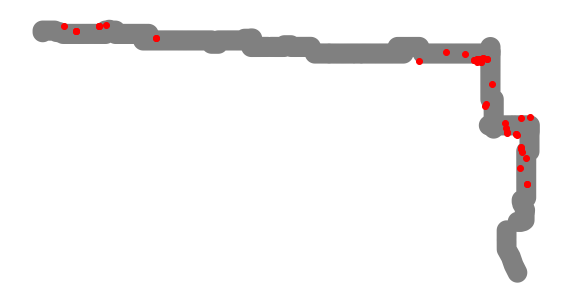

In [383]:
lithoprobe_buffer_wgs84 = lithoprobe_utm.to_crs(crs=4326)

well_subset_utm = gpd.overlay(wells_utm, lithoprobe_utm)
well_subset = well_subset_utm.to_crs(crs=4326)
print("Number of wells", buffer/1000, "km from the lithoprobe line:", well_subset.shape[0])

fig, ax = plt.subplots(figsize=(10, 10))
lithoprobe_buffer_wgs84.plot(ax=ax,color='grey')
well_subset.plot(ax=ax,color='red')
ax.set_axis_off()
ax.grid(True)
plt.show()

In [388]:
m = folium.Map(location=[55.91, -120],zoom_start=8, width=900, height=400, control_scale=True)

for row in well_subset.iterrows():

    location = ([row[1][0], row[1][1]])
    popup = ('Well Identifier' + row[1][5] 
             + '\nlat:' + str(row[1][0]) + 
             '\nlon:' + str(row[1][1]))
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(m) 

folium.GeoJson(lithoprobe).add_to(m)
folium.GeoJson(tgs_seismic).add_to(m)

folium.GeoJson(monitoring_areas,
    style_function=lambda x: {
        'color' : 'red',
        'weight' : 2,
        'opacity': 0.7,
        'fillColor' : 'blue',
        }).add_to(m)

m

In [389]:
##### import plugin from folium
from folium import plugins# big map
big_map = folium.Map(location=(52, -118), zooom_start = 1)# add plugin mini map
mini_map = plugins.MiniMap(toggle_display=True)# add the mini map to the big map
big_map.add_child(mini_map)
big_map

change coordinates to UTM Nad27 (epsg=26711)

In [147]:
lithoprobe_26711 = lithoprobe.to_crs(epsg=26711)
faults_26711 = faults.to_crs(epsg=26711)

get intersection of the lithoprobe lines with the faults 

In [390]:
# https://gis.stackexchange.com/questions/252474/intersecting-lines-to-get-points-in-geopandas

points = lithoprobe_26711.unary_union.intersection(faults_26711.unary_union)
points_gs = GeoSeries(point for point in points)# from geopandas import GeoSeries

points_gdf = gpd.GeoDataFrame(gpd.GeoSeries(points_gs))
points_gdf = points_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')
points_gdf.crs = {'init':'epsg:26711'}

C:\Users\Paulina-laptop\AppData\Roaming\Python\Python37\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Plot it together and show easting coordinate of the intersected points

epsg:26711


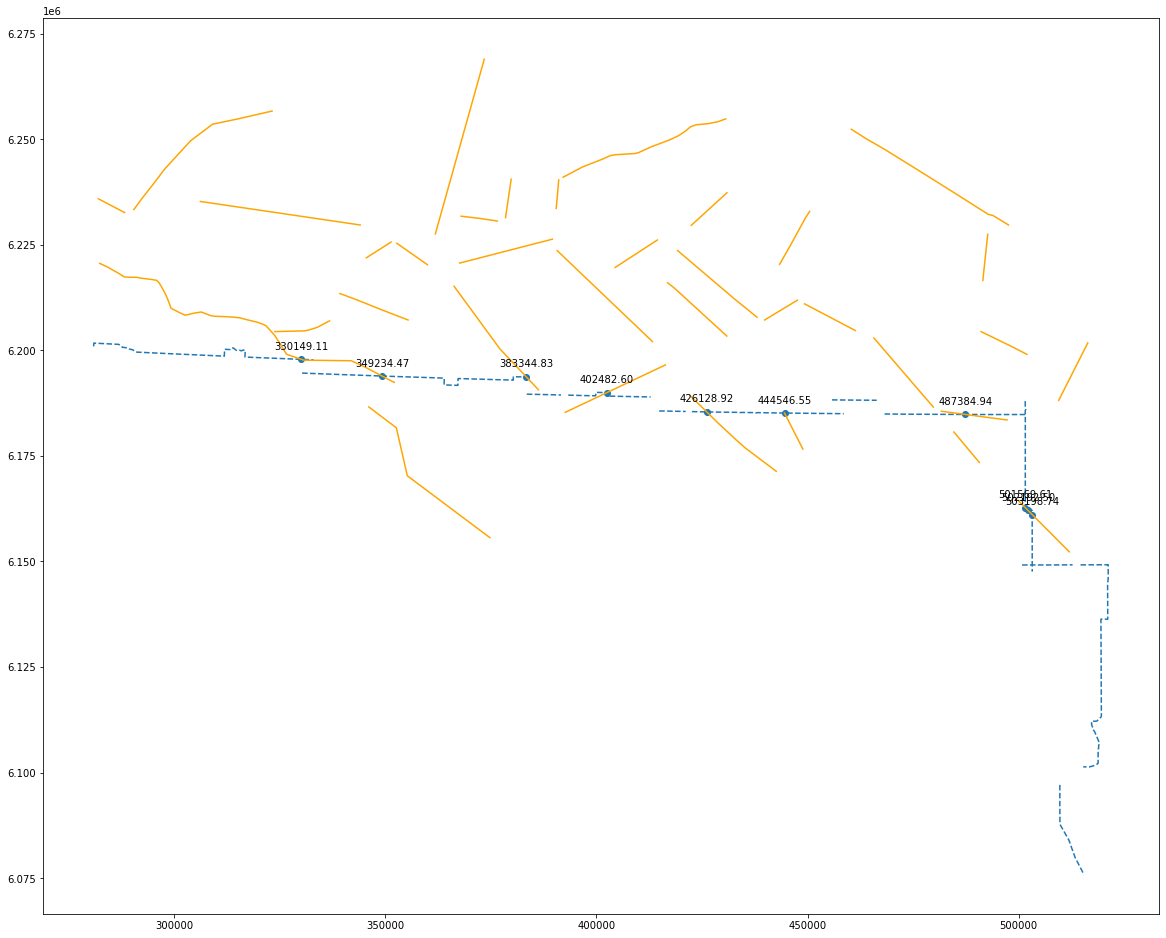

In [405]:

print(lithoprobe_26711.crs)

fig, ax = plt.subplots(1,1, figsize=(20,20))
lithoprobe_26711.plot(ax = ax, linestyle='dashed')
faults_26711.plot(ax=ax, color='orange')
points_gdf.plot(ax=ax)
for x,y in zip(points_gdf['geometry'].x,points_gdf['geometry'].y):

    label = "{:.2f}".format(x)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# plt.show()

we can also plot it as interactive map, using folium. To do that, we need to convert the shapefiles to geojson first

this part is used to create the geojson from the shapefile

In [192]:
"""
points_gdf.to_file("faults_lithoprobe_intersection.shp", driver='ESRI Shapefile')
shp_file = geopandas.read_file('faults_lithoprobe_intersection.shp')
shp_file.to_file('faults_lithoprobe_intersection.geojson', driver='GeoJSON')
""";

let's convert the crs to WGS84 first

In [ ]:
points_file = os.path.join("F:/", "NRCan","shapefiles", "draft", "faults_lithoprobe_intersection.geojson")
points = gpd.read_file(points_file)

points_wgs84 = points.to_crs(crs=4326)
lithoprobe_wgs84 = lithoprobe.to_crs(crs=4326)
faults_wgs84 = faults.to_crs(crs=4326)

We can check how the map looks in geographic coordinates

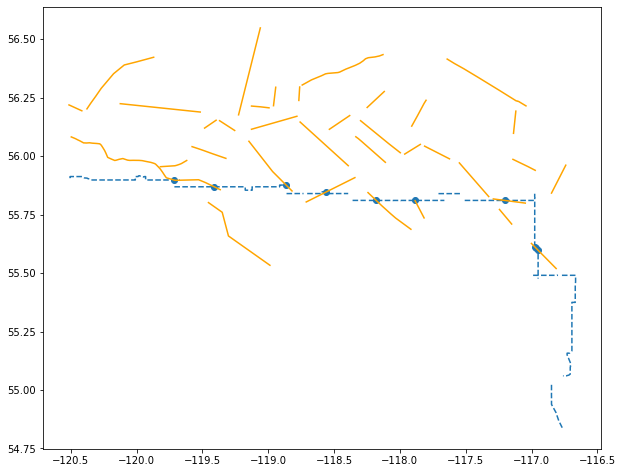

In [205]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
lithoprobe_wgs84.plot(ax = ax, linestyle='dashed')
faults_wgs84.plot(ax=ax, color='orange')
points_wgs84.plot(ax=ax);

In [206]:
# create folium map

In [393]:
m = folium.Map(location=[55.91, -119],zoom_start=8, width=900, height=400, control_scale=True)

for row in points_wgs84.iterrows():
    location = (row[1][1].y, row[1][1].x)
    popup = ('\nlatitude:' + 
             str((row[1][1].x)) + 
             '\nlongitude:' + str(row[1][1].y))
    marker = folium.Marker(location = location, popup = popup, color='green')
    marker.add_to(m) 
  

folium.GeoJson(faults_wgs84).add_to(m)

folium.GeoJson(lithoprobe_wgs84,
    style_function=lambda x: {
        'color' : 'red',
        'weight' : 2,
        'opacity': 0.7,
        'fillColor' : 'blue',
        }).add_to(m)

m

more on icons change: https://stackoverflow.com/questions/60131314/folium-draw-star-marker